# Joshua Krachman and Zachary Zarubin Lab #2
## Biomedical Data Science Lab: 09/27

# Classification of cardiomyocites based on their action potentials
In this lab experience we will be looking at the problem of classifying cardiac cells by looking at
their _Action Potentials_ (APs). For the purpose of this task we will be using synthetically
generated APs following the models in [(Nygren et. al, 1998)](https://www.ahajournals.org/doi/abs/10.1161/01.res.82.1.63) and [(O'Hara et. al, 2011)](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1002061).

### Objectives
By the end of this session you should be able to use nearest-neighbor and simple neural network classifiers for two-class classification problems.

* _Note: Everything below this line should be truned in as part of your lab report._


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# ============================================================================
# import modules
# ============================================================================
# Note that this part of the code needs to be run prior to any other code cell

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import random as rnd
import torch

# inline plots
%matplotlib inline

# set random number generator seed
rnd.seed(10)

# mount GDrive
from google.colab import drive
drive.mount('gdrive/')

# ============================================================================
# data loading
# ============================================================================

# PLEASE, SPECIFY YOUR PATH TO THE DATA HERE
datapath = 'gdrive/My Drive/Data Science/Lab Course Labs/lab2'

# get the list of files to process
matfile = '/'.join((datapath,'Adult_samples.mat'))

# get data as dictionary
adata = scipy.io.loadmat(matfile)

# see the keys of the dictionary 'Vatrial' and 'Vventricular'
# adata['Vatrial'] contains action potentials of cardiac cells of atrial type
# adata['Vventricular'] contains action potentials of cardiac cells of ventricular type
adata.keys()


Mounted at gdrive/


dict_keys(['__header__', '__version__', '__globals__', 'Vatrial', 'Vventricular'])

Text(0.5, 0, 'sample')

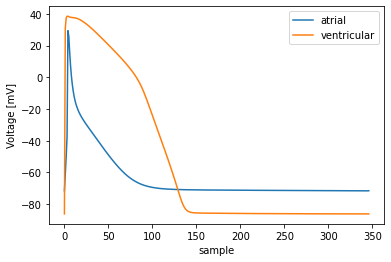

In [3]:
# look at the data dimensions
adata['Vatrial'].shape

# let's see how the data looks like
plt.plot(adata['Vatrial'][:,0])
plt.plot(adata['Vventricular'][:,0])
plt.legend(('atrial','ventricular'))
plt.ylabel('Voltage [mV]')
plt.xlabel('sample')

### Task 1. Pre-processing and manual feature extraction
In this first part we will be normalizing the data and extracting hand-crafted features that will be later
used for the classification task. Load the dataset **Adult_samples.mat** that contains examples of
adult atrial and ventricular action potentials generated using the models in [(Nygren et al., 1998)](https://www.ahajournals.org/doi/abs/10.1161/01.res.82.1.63) and [(O'Hara et al., 2011)](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1002061).
For each of the two classes there are $1000$ samples generated with a sampling rate of $f_s=500$ Hz.

* _(15 points) Data preparation and normalization._
Split the data between test and training sets by
randomly selecting $10\%$ of the points as your training set. Make sure the two classes are well represented
in the training set (e.g., use the same number for both). Normalize the data so that each AP has zero resting potential and unit maximum amplitude. Create an array of corresponding labels for the data points. For ventricular type use the class label $+1$ and $-1$ for
atrial type.
Make two plots displaying your normalized training data for each of the classes. Use time units for the horizontal axis.

Text(0, 0.5, 'Normalized Voltage (mV)')

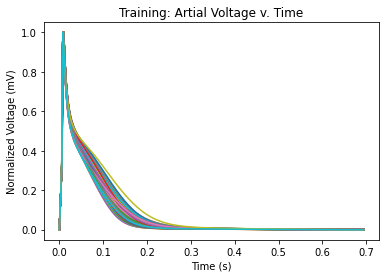

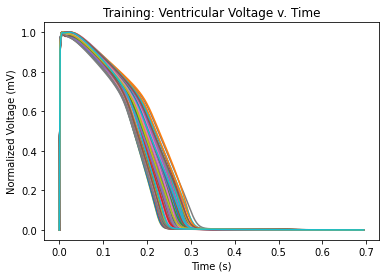

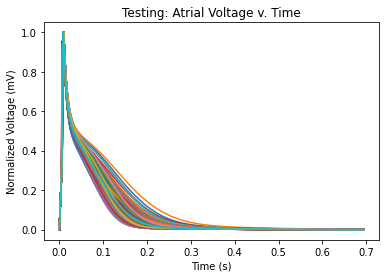

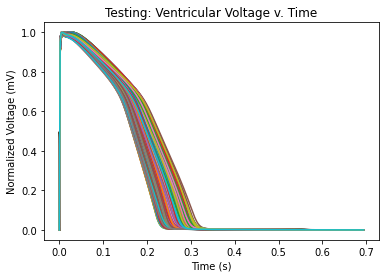

In [4]:
samp = rnd.sample(range(0,1000), 100)
booleanlist = [i in samp for i in range(0,1000)]

X_training_a = adata['Vatrial'][:, booleanlist]
X_training_v = adata['Vventricular'][:, booleanlist]
X_training = np.append(X_training_a, X_training_v,axis=1)

X_testing_a = adata['Vatrial'][:, [not t for t in booleanlist]]
X_testing_v = adata['Vventricular'][:, [not t for t in booleanlist]]
X_testing = np.append(X_testing_a, X_testing_v, axis=1)

X_training = (X_training - X_training[346])           
X_training = (X_training/np.max(X_training, axis = 0))
X_testing = (X_testing - X_testing[346])
X_testing =  (X_testing/np.max(X_testing, axis = 0))

Class = np.ones(200)
Class[0:100] = -1

t = np.linspace(0, (347/500), 347)
plt.figure()
plt.plot(t, X_training[:,(Class == -1)])
plt.title('Training: Artial Voltage v. Time')
plt.xlabel('Time (s)')
plt.ylabel('Normalized Voltage (mV)')

plt.figure()
plt.plot(t, X_training[:,~(Class == -1)])
plt.title('Training: Ventricular Voltage v. Time')
plt.xlabel('Time (s)')
plt.ylabel('Normalized Voltage (mV)')


Class_test = np.ones(1800)
Class_test[0:900] = -1

t = np.linspace(0, (347/500), 347)
plt.figure()
plt.plot(t, X_testing[:,(Class_test == -1)])
plt.title('Testing: Atrial Voltage v. Time')
plt.xlabel('Time (s)')
plt.ylabel('Normalized Voltage (mV)')

plt.figure()
plt.plot(t, X_testing[:,~(Class_test == -1)])
plt.title('Testing: Ventricular Voltage v. Time')
plt.xlabel('Time (s)')
plt.ylabel('Normalized Voltage (mV)')


X_testing.shape

In [5]:
X_testing.shape

(347, 1800)

* _(20 points) Hand-crafted features._
The _Action Potential Duration_ (APD) at $x\%$ is defined as the time
it takes to reduce the maximum amplitude of the AP to $x\%$ of its value. Write a function that computes APD at a given
percentage $x\in[0,1]$. Compute also the _Average of the Action Potential_ (AAP) and build two-dimensional features
by concatenating APD@$0.5$ and AAP. Make a scatter plot of the training data using these two features. Use
different colors and/or markers to represent each class.

    * Based on your scatter plot, is the training data using the above features linearly separable? Why?

In [6]:
# ============================================================================
# compute hand-crafted features such as AAP and APDx
# ============================================================================

def apdx(X,alpha=0.5,fs=1.0):
    """
    This function computes the APDx feature defined as the time it takes to
    reduce the action potential to x% of its maximum value.
    Use:
        APD = apdx(X,alpha,fs)
        
    Inputs:
        X : data points (each column is a data point)
        alpha : [0,1] percentage of maximum amplitude
        fs : sampling frequency (to map samples to time)
        
    Output:
        APD feature
    """

 
    # Make array of APD values for X
    APD_arr = []
    for i in range(0, X.shape[1]):
      max_time = np.argmax(X[:,i])/fs
      findmintemp = []
      for j in range(0, X.shape[0]):
        findmin = alpha - X[j,i]
        newfindmin = (np.absolute(findmin))
        findmintemp.append(newfindmin)
      alpha_percent_time = np.argmin(findmintemp) / fs

      APD_arr.append(np.subtract(alpha_percent_time,max_time))
    return APD_arr
  
  
print('APD@0.5 of the Action Potential') 
print(apdx(X_training,fs = 500))

def avg(X,alpha=0.5,fs=1.0):
    
    
    Avg_arr = []
    for i in range(0, X.shape[1]):
      counter = 0
      for j in range(X.shape[0]):
        counter += X[j, i]
      
      averageV = counter/(X.shape[0])
    
      
      Avg_arr.append(averageV)
    return Avg_arr

print(avg(X_training, fs = 500))

npapd = np.asarray(apdx(X_training,fs = 500))
npavg = np.asarray(avg(X_training, fs = 500))

newapd = npapd 
newavg = npavg
newapd = np.reshape(newapd, (-1,1))
newavg = np.reshape(newavg,(-1,1))   
  
featurelist = np.concatenate((newapd,newavg), axis = 1)


APD@0.5 of the Action Potential
[0.024, 0.022, 0.022, 0.024, 0.027999999999999997, 0.027999999999999997, 0.024, 0.022, 0.022, 0.02, 0.026000000000000002, 0.022, 0.024, 0.019999999999999997, 0.027999999999999997, 0.026000000000000002, 0.019999999999999997, 0.024, 0.026000000000000002, 0.026000000000000002, 0.024, 0.026000000000000002, 0.019999999999999997, 0.022, 0.026000000000000002, 0.024, 0.019999999999999997, 0.02, 0.027999999999999997, 0.02, 0.027999999999999997, 0.024, 0.02, 0.02, 0.024, 0.019999999999999997, 0.02, 0.022, 0.027999999999999997, 0.027999999999999997, 0.02, 0.018000000000000002, 0.024, 0.022, 0.027999999999999997, 0.018, 0.027999999999999997, 0.03, 0.022, 0.024, 0.027999999999999997, 0.022, 0.019999999999999997, 0.027999999999999997, 0.018000000000000002, 0.018000000000000002, 0.018, 0.022, 0.024, 0.022, 0.022, 0.022, 0.024, 0.022, 0.02, 0.022, 0.02, 0.022, 0.026000000000000002, 0.027999999999999997, 0.027999999999999997, 0.019999999999999997, 0.019999999999999997, 0

In [7]:
newapd = np.reshape(newapd, (-1,1))
newagv = np.reshape(newavg,(-1,1)) 
newapd.shape
newavg.shape

(200, 1)

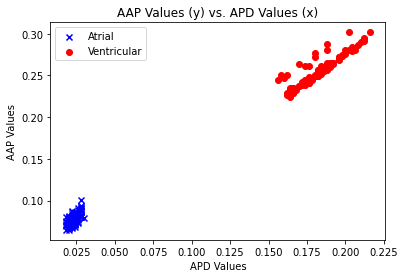

In [8]:
plt.scatter(newapd[0:100],newavg[0:100], c='b', marker='x', label='Atrial')
plt.scatter(newapd[101:200],newavg[101:200], c='r', marker='o', label='Ventricular')
plt.legend(loc='upper left')
plt.title('AAP Values (y) vs. APD Values (x)')
plt.ylabel('AAP Values')
plt.xlabel('APD Values')
plt.show()

# Written Part Answer:
The training data is linearly sepearble because you can draw a clear line between the Atrial and Ventricular Action Potentials

### Task 2. Classification

* _(15 points) Nearest-neighbor classifier._
Implement a $1$NN classifier using the Euclidean distance. A $1$NN classifier works as follows: Given your training dataset $\mathcal{D} = \big\{(\boldsymbol x_i,y_i)\big\}_{i=1}^{N}$,where $N$ is the number of training samples, $\boldsymbol x_i\in\mathbb{R}^D$ is a feature vector and $y_i\in\{-1,1\}$ its associated label, and a novel sample $\boldsymbol x$, the $1$NN classifier assigns to $\boldsymbol x$ the same label as its closest point in the training set. That is, the estimated label $\widehat y$ of $\boldsymbol x$ is such that:

\begin{equation}
	\widehat y(\boldsymbol x) = y_{k^*},\quad k^* = \underset{i\in\{1,\ldots,N\}}{\arg\min}\, \lVert \boldsymbol x_i - \boldsymbol x \rVert_2.
\end{equation}

Compute and display the classification accuracy over the test set using the handcrafted training features of **Task 1**.

In [9]:
# ============================================================================
# Nearest-neighbor classifier
# ============================================================================

def nn_classify(Xtest,Xtrain,ytrain):
    """
    This function implements a nearest neighbor classifier.
    Use:
        yhat = nn_classify(Xtest,Xtrain,ytrain)
        
    Inputs:
        Xtest  : test data points (each column is a data point)
        Xtrain : training data points
        ytrain : associated labels to the training data points
        
    Output:
        yhat : estimated labels for the test data.

    """
    
    # implement your NN classifier below
    # ...
    Xtestapd = np.asarray(apdx(Xtest,fs = 500))
    Xtestavg = np.asarray(avg(Xtest, fs = 500))
    Xtestapd = np.reshape(Xtestapd, (-1,1))
    Xtestavg = np.reshape(Xtestavg,(-1,1)) 
    
           
    featurelisttest = np.concatenate((Xtestapd,Xtestavg), axis = 1)
    
    Xtrainapd = np.asarray(apdx(Xtrain,fs = 500))
    Xtrainavg = np.asarray(avg(Xtrain, fs = 500))
    Xtrainapd = np.reshape(Xtrainapd, (-1,1))
    Xtrainavg = np.reshape(Xtrainavg,(-1,1)) 
    
           
    featurelisttrain = np.concatenate((Xtrainapd,Xtrainavg), axis = 1)
    
    
    
    list=[]
    for i in range(0,Xtest.shape[1]):
      d = np.sum((Xtrain-Xtest[:,i].reshape((-1,1)))**2,axis=0)
      idx = np.argmin(d)
      list.append(idx)

    predicts = []
    for i in range (0, len(list)):
      predicts.append(ytrain[list[i]])
    
    print(len(predicts))
    return predicts
                                  
    
estimated = nn_classify(X_testing,X_training,Class) 
counter = 0
for ind in range(0,Class_test.shape[0]):
  if estimated[ind] == Class_test[ind]:
   counter += 1
accuracy = counter / Class_test.shape[0]
                      
print('Classification accuracy over the test set=', accuracy)                     


1800
Classification accuracy over the test set= 1.0


* _(40 points) Two-layer Neural Network._
 Implement a two-layer neural network classifier of the form:

   $$\widehat y = \operatorname{sign}\big(f_{\theta}(\phi(\boldsymbol x))\big),\quad f_{\theta}(\phi(\boldsymbol x)) = \boldsymbol w^T\phi(\boldsymbol x) + b,\quad \theta = \left[\begin{array}{c}\boldsymbol w\\b\end{array}\right],$$
  
 where $f_\theta(\cdot)$ is a _linear prediction function_ (i.e., classification layer) parametrized by $\theta = [\boldsymbol w^T, b]^T$. The feature extraction part of the network consists of a linear layer followed by a ReLu (rectified linear unit) non-linearity:
 
 $$ \phi(x) = \operatorname{ReLu}\big(\boldsymbol W_1 \boldsymbol x + \boldsymbol b_1\big),\quad\operatorname{ReLu}(x)=\begin{cases}x &x>0\\0&\textrm{else}\end{cases}.$$
 
 In order to find the network's parameters $\Theta=\{\boldsymbol W_1, \boldsymbol b_1, \boldsymbol w, b\}$ minimize the following _regularized empirical risk_ using PyTorch:

   $$\min_{\Theta}\, \underbrace{\frac{1}{N} \sum_{i=1}^N L\big(f_\theta(\phi(\boldsymbol x_i)),y_i\big) + \lambda\big(\frac{1}{w}\lVert \boldsymbol w\rVert^2 + \frac{1}{W}\lVert\boldsymbol W_1\rVert^2\big)}_{C(\Theta)}$$
    
 where the loss function $L(f, y) = \lVert y-f\rVert_2^2)$ is the quadratic (square) loss, and $w,W$, are the number of elements in $\boldsymbol w$ and $\boldsymbol W$, respectively. 

    * Define a network model in PyTorch according to the definition above. For that purpose you can use `torch.nn.Sequential`. Follow this [example](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#pytorch-nn) to learn how to use it.
    
    * Run a gradient descent algorithm to minimize the cost function using $\lambda =1$. Carefully choose the stepsize and number of iterations until you see the method converges (i.e., the cost function gets to a "plateau").
    
    * Make a scatter plot of the learned features (i.e., prior to classificaiton layer) by your network model. Has your model learned features that are linearly separable? Display in the scatter plot the decision boundary that you have learned. Compute the classification accuracy over the test set.
    
    * Plot the weights of the learned linear layer. What has your network learned?



200
347
torch.Size([2, 347])


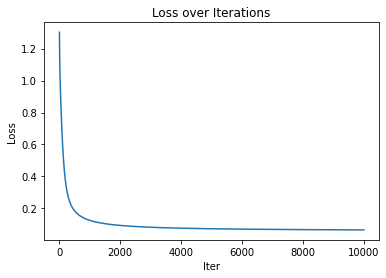

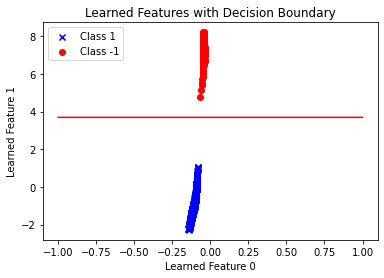

In [10]:
import torch
torch.manual_seed(0)

N, D_in, H, D_out = X_training.shape[1], X_training.shape[0], 2, 1
#N, D_in, H, D_out = 2000, 347, 2, 1
print(X_training.shape[1])
print(X_training.shape[0])

lambdaval = 1
linlay = torch.nn.Linear(D_in,H)
ReLUu = torch.nn.ReLU()
classlay = torch.nn.Linear(H,D_out)


model = torch.nn.Sequential(
  linlay,
  ReLUu,
  classlay,


)


Lossfunction = torch.nn.MSELoss(reduction='mean')
Losslist = []

X_trainingnew = torch.from_numpy(np.transpose(np.array(X_training))).float()

classlabel = torch.from_numpy(Class.reshape((-1,1))).float()
X_testingnew = torch.from_numpy(np.transpose(np.array(X_testing))).float()

classtest_label = torch.from_numpy(Class_test.reshape(-1,1)).float()

learning_rate = 1e-2
for t in range(10000):
  yhat = model(X_trainingnew)
  loss = Lossfunction(yhat, classlabel) + lambdaval * (linlay.weight.pow(2).mean() + classlay.weight.pow(2).mean())
  Losslist.append(loss)
  model.zero_grad()
  loss.backward()
  
  with torch.no_grad():
    for param in model.parameters():
      param -= learning_rate * param.grad
           
plt.figure()
plt.plot(Losslist)
plt.xlabel('Iter')
plt.ylabel('Loss')
plt.title('Loss over Iterations')

Yclassify = model(X_testingnew).detach().numpy()
Yclassify = np.sign(Yclassify)
indexes = []
for i in range(len(Yclassify)):
  if Yclassify[i] == 1:
     indexes.append(i)
      
xoneval = []      
yoneval = []
xnegval = []
ynegval = []

for int in range(len(Yclassify)):
  if int in indexes:
    xoneval.append(linlay(X_testingnew).detach().numpy()[:,0][int])
    yoneval.append(linlay(X_testingnew).detach().numpy()[:,1][int])
  else:
    xnegval.append(linlay(X_testingnew).detach().numpy()[:,0][int])
    ynegval.append(linlay(X_testingnew).detach().numpy()[:,1][int])

plt.figure()
plt.scatter(xoneval,yoneval, c='b', marker='x', label='Class 1')
plt.scatter(xnegval,ynegval, c='r', marker='o', label='Class -1')
plt.legend(loc='upper left')
plt.xlabel('Learned Feature 0')
plt.ylabel('Learned Feature 1')
plt.title('Learned Features with Decision Boundary')
print(linlay.weight.shape)

x = np.linspace(-1,1,1800)
x = torch.from_numpy(x).float()
y = (classlay.weight[0,0]* x * (-1)  - classlay.bias) / classlay.weight[0,1]
plt.plot(x.detach().numpy(), y.detach().numpy(), '-r')




Model has learned features that are linearly seperable. 

(200,)


Text(0.5, 0, 'Inputs of the Model')

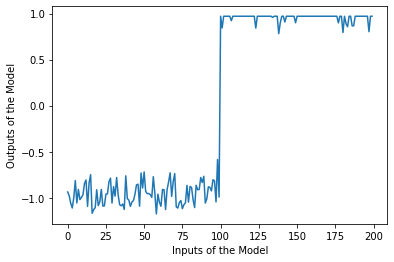

In [11]:
yhat.shape
print(Class.shape)
classlabel.shape
plt.plot(yhat.detach().numpy())
plt.ylabel('Outputs of the Model')
plt.xlabel('Inputs of the Model')

Test Set Class. Accuracy = 1.0


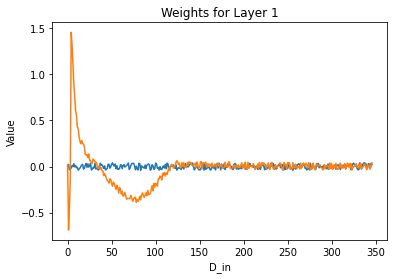

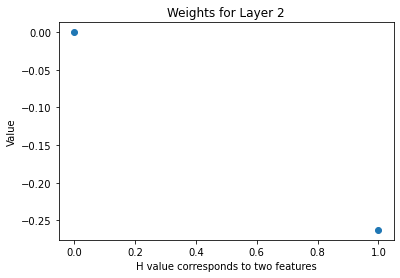

In [12]:
Yclass = model(X_testingnew).detach().numpy()
Yclass = np.sign(Yclass)
Yclass = np.transpose(Yclass)
finaccuracy = np.sum(Yclass == Class_test) / 1800
print('Test Set Class. Accuracy = ' + str(finaccuracy))

Yclass_new = model(X_trainingnew).detach().numpy()


Yclass_new = np.sign(Yclass_new)
Yclass_new = np.transpose(Yclass_new)

plt.figure()
plt.title('Weights for Layer 1')
plt.ylabel('Value')
plt.xlabel('D_in')
plt.plot(linlay.weight.detach().numpy().transpose())

plt.figure()
plt.title('Weights for Layer 2')
plt.ylabel('Value')
plt.xlabel('H value corresponds to two features')
plt.scatter(range(H), classlay.weight.detach().numpy()[0])

#Written Answer
The network has learned the weights used to compress the information from each input(size 347) to two features(2)
The network also has learned the weights used to interpret the two features of each input to derive an output that corresponds to what class the input originally belonged to. The output of the network goes into a sign function in order to be assigned to the eventual label: 1 or -1. The second graph shows that one of the two features does not matter in determining the output of the network. Only one of the two features is actual used to determine the output, which corresponds to the correct class after the sign function is applied. The first graph shows all the weights used on the 347 time steps of each input to compress this to two features.